<a href="https://colab.research.google.com/github/KatBCN/MUD-Lab-LangDet/blob/main/Assignment1_MUD_KW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mining Unstructured Data - Lab 1

## Introduction

Studying the impact of different processing techniques on NLP task.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!pip install utils
#from utils import *

In [2]:
import argparse
import numpy as np
import nltk
import matplotlib.pyplot as plt
import pandas as pd
import random
import scipy
import seaborn as sn
import colorcet as cc
import re


from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.decomposition import PCA

from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split


In [3]:
#preprocess

#Tokenizer function. You can add here different preprocesses.
def preprocess(sentence, labels):
    '''
    Task: Given a sentence apply all the required preprocessing steps
    to compute train our classifier, such as sentence splitting, 
    tokenization or sentence splitting.

    Input: Sentence in string format
    Output: Preprocessed sentence either as a list or a string
    '''
    # Place your code here
    # Keep in mind that sentence splitting affectes the number of sentences
    # and therefore, you should replicate labels to match.
    return sentence,labels

In [4]:
# classifiers

# You may add more classifier methods replicating this function
def applyNaiveBayes(X_train, y_train, X_test):
    '''
    Task: Given some features train a Naive Bayes classifier
          and return its predictions over a test set
    Input; X_train -> Train features
           y_train -> Train_labels
           X_test -> Test features 
    Output: y_predict -> Predictions over the test set
    '''
    trainArray = toNumpyArray(X_train)
    testArray = toNumpyArray(X_test)
    
    clf = MultinomialNB()
    clf.fit(trainArray, y_train)
    y_predict = clf.predict(testArray)
    return y_predict

In [5]:
# utils

def compute_features(X_train, 
                     X_test, 
                     analyzer='char', 
                     max_features=None):
  '''
  Task: Compute a matrix of token counts given a corpus. 
        This matrix represents the frecuency any pair of tokens appears
        together in a sentence.
 
  Input: X_train -> Train sentences
         X_test -> Test sentences
         analyzer -> Granularity used to process the sentence 
                    Values: {word, char}
         tokenizer -> Callable function to apply to the sentences before compute.
  
  Output: unigramFeatures: Cout matrix
          X_unigram_train_raw: Features computed for the Train sentences
          X_unigram_test_raw: Features computed for the Test sentences 
  '''
  
  unigramVectorizer = CountVectorizer(analyzer=analyzer,
                                      max_features=max_features,
                                      ngram_range=(1,1))
  
  X_unigram_train_raw = unigramVectorizer.fit_transform(X_train)
  X_unigram_test_raw = unigramVectorizer.transform(X_test)
  unigramFeatures = unigramVectorizer.get_feature_names()
  return unigramFeatures, X_unigram_train_raw, X_unigram_test_raw
    


def compute_coverage(features, split, analyzer='char'):
  '''
  Task: Compute the proportion of a corpus that is represented by
        the vocabulary. All non covered tokens will be considered as unknown
        by the classifier.
  
  Input: features -> Count matrix
         split -> Set of sentence 
         analyzer -> Granularity level {'word', 'char'}
  
  Output: proportion of covered tokens
  '''
  total = 0.0
  found = 0.0
  for sent in split:
    #The following may be affected by your preprocess function. Modify accordingly
    sent = sent.split(' ') if analyzer == 'word' else list(sent)
    total += len(sent)
    for token in sent:
      if token in features:
        found += 1.0
  return found / total

# Utils for conversion of different sources into numpy array
def toNumpyArray(data):
    '''
    Task: Cast different types into numpy.ndarray
    Input: data ->  ArrayLike object
    Output: numpy.ndarray object
    '''
    data_type = type(data)
    if data_type == np.ndarray:
        return data
    elif data_type == list:
        return np.array(data_type)
    elif data_type == scipy.sparse.csr.csr_matrix:
        return data.toarray()
    print(data_type)
    return None    
  
def normalizeData(train, test):
    '''
    Task: Normalize data to train classifiers. This process prevents errors
          due to features with different scale
    
    Input: train -> Train features
           test -> Test features

    Output: train_result -> Normalized train features
            test_result -> Normalized test features
    '''
    train_result = normalize(train, norm='l2', axis=1, copy=True, return_norm=False)
    test_result = normalize(test, norm='l2', axis=1, copy=True, return_norm=False)
    return train_result, test_result


def plot_F_Scores(y_test, y_predict):
    '''
    Task: Compute the F1 score of a set of predictions given
          its reference

    Input: y_test: Reference labels 
           y_predict: Predicted labels

    Output: Print F1 score
    '''
    f1_micro = f1_score(y_test, y_predict, average='micro')
    f1_macro = f1_score(y_test, y_predict, average='macro')
    f1_weighted = f1_score(y_test, y_predict, average='weighted')
    print("F1: {} (micro), {} (macro), {} (weighted)".format(f1_micro, f1_macro, f1_weighted))

def plot_Confusion_Matrix(y_test, y_predict):
    cmap = sn.cubehelix_palette(20, start=.1, rot=-.75)
    '''
    Task: Given a set of reference and predicted labels plot its confussion matrix
    
    Input: y_test ->  Reference labels
           y_predict -> Predicted labels
           color -> [Optional] Color used for the plot
    
    Ouput: Confussion Matrix plot
    '''
    allLabels = list(set(list(y_test) + list(y_predict)))
    allLabels.sort()
    confusionMatrix = confusion_matrix(y_test, y_predict, labels=allLabels)
    unqiueLabel = np.unique(allLabels)
    df_cm = pd.DataFrame(confusionMatrix, columns=unqiueLabel, index=unqiueLabel)
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
    sn.set(font_scale=0.8) # for label size
    sn.set(rc={'figure.figsize':(15, 15)})
    sn.heatmap(df_cm, cmap=cmap, annot=True, annot_kws={"size": 12}, fmt='g', linewidth=0.3, cbar_kws={"shrink": .8})# font size
    plt.show()


def plotPCA(x_train, x_test,y_test, langs):
    '''
    Task: Given train features train a PCA dimensionality reduction
          (2 dimensions) and plot the test set according to its labels.
    
    Input: x_train -> Train features
           x_test -> Test features
           y_test -> Test labels
           langs -> Set of language labels

    Output: Print the amount of variance explained by the 2 first principal components.
            Plot PCA results by language
            
    '''
    pca = PCA(n_components=2)
    pca.fit(toNumpyArray(x_train))
    pca_test = pca.transform(toNumpyArray(x_test))
    print('Variance explained by PCA:', pca.explained_variance_ratio_)
    y_test_list = np.asarray(y_test.tolist())
    pale=sn.color_palette(cc.glasbey, n_colors=25)
    markis = ['d','^','^','s','.','s','.','.','.','s','^','.','^','^','.','^','.','.','.','s','^','.','.']
    indexito=0
    for lang in langs:
        indexito +=1
        pca_x = np.asarray([i[0] for i in pca_test])[y_test_list == lang]
        pca_y = np.asarray([i[1] for i in pca_test])[y_test_list == lang]
        plt.scatter(pca_x,pca_y, label=lang,color=pale[indexito],marker=markis[indexito] )
    plt.legend(loc="upper left")
    plt.show()


In [6]:
# langdetect
seed = 42
random.seed(seed)


def get_parser():
    parser = argparse.ArgumentParser()
    parser.add_argument("-i", "--input", 
                        help="Input data in csv format", type=str)
    parser.add_argument("-v", "--voc_size", 
                        help="Vocabulary size", type=int)
    parser.add_argument("-a", "--analyzer",
                         help="Tokenization level: {word, char}", 
                        type=str, choices=['word','char'])
    return parser


def results (input, vocabulary, analyzer):
    #parser = get_parser()
    #args = parser.parse_args()
    raw = pd.read_csv(input)
    
    # Languages
    languages = set(raw['language'])
    print('========')
    print('Languages', languages)
    print('========')

    # Split Train and Test sets
    X=raw['Text']
    y=raw['language']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
    
    print('========')
    print('Split sizes:')
    print('Train:', len(X_train))
    print('Test:', len(X_test))
    print('========')
    
    # Preprocess text (Word granularity only)
    if analyzer == 'word':
        X_train, y_train = preprocess(X_train,y_train)
        X_test, y_test = preprocess(X_test,y_test)

    #Compute text features
    features, X_train_raw, X_test_raw = compute_features(X_train, 
                                                            X_test, 
                                                            analyzer=analyzer, 
                                                            max_features=vocabulary)

    print('========')
    print('Number of tokens in the vocabulary:', len(features))
    print('Coverage: ', compute_coverage(features, X_test.values, analyzer=analyzer))
    print('========')


    #Apply Classifier  
    X_train, X_test = normalizeData(X_train_raw, X_test_raw)
    y_predict = applyNaiveBayes(X_train, y_train, X_test)
    
    print('========')
    print('Prediction Results:')    
    plot_F_Scores(y_test, y_predict)
    print('========')
    
    plot_Confusion_Matrix(y_test, y_predict) 


    #Plot PCA
    print('========')
    print('PCA and Explained Variance:') 
    plotPCA(X_train, X_test,y_test, languages) 
    print('========')

# Data Exploration

In [7]:
path = '/content/drive/MyDrive/MUD-Lab1/dataset.csv'

In [8]:
input = path

The data consists of many rows with two columns. The first column is a sample text, and the second column is the label for the language of the text in the first column.

In [9]:
data = pd.read_csv(input)
data.head()

,Text,language
0,klement gottwaldi surnukeha palsameeriti ning ...,Estonian
1,sebes joseph pereira thomas på eng the jesuit...,Swedish
2,ถนนเจริญกรุง อักษรโรมัน thanon charoen krung เ...,Thai
3,விசாகப்பட்டினம் தமிழ்ச்சங்கத்தை இந்துப் பத்திர...,Tamil
4,de spons behoort tot het geslacht haliclona en...,Dutch


In [10]:
# size of data set
data.shape

(22000, 2)

In [11]:
# number of samples per lanugage
data.language.value_counts()

Estonian      1000
Swedish       1000
English       1000
Russian       1000
Romanian      1000
Persian       1000
Pushto        1000
Spanish       1000
Hindi         1000
Korean        1000
Chinese       1000
French        1000
Portugese     1000
Indonesian    1000
Urdu          1000
Latin         1000
Turkish       1000
Japanese      1000
Dutch         1000
Tamil         1000
Thai          1000
Arabic        1000
Name: language, dtype: int64

There are 22 languages in the data set. Each language has 1000 samples inlcuded.

In [12]:
# number of unique languages
len(data.language.unique())

22

Some samples contain sentences which contain words from mulitple languages, as seen in the Urdu example below with English words. The Thai example also contains a mix of words written in Thai and Latin scripts.

From the samples below, we can see that at least eleven languages (half of the data set) use characters based on [latin script](https://en.wikipedia.org/wiki/Latin_script):


1. Estonian
2. Swedish
3. Dutch
4. Turkish
5. Latin
6. Indonesian
7. Portugese
8. French
9. Spanish
10. Romanian
11. English

Four languages use characters based on [arabic script](https://en.wikipedia.org/wiki/Arabic_script):

1. Urdu
2. Pushto
3. Persian
4. Arabic

Seven languages appear to have unique scripts, character sets, or writing systems.

1. [Thai](https://en.wikipedia.org/wiki/Thai_script)
2. [Tamil](https://en.wikipedia.org/wiki/Tamil_script)
3. [Japanese](https://en.wikipedia.org/wiki/Japanese_writing_system)
4. [Chinese](https://en.wikipedia.org/wiki/Chinese_characters)
5. [Korean](https://en.wikipedia.org/wiki/Hangul)
6. [Hindi](https://en.wikipedia.org/wiki/Devanagari)
7. [Russian](https://en.wikipedia.org/wiki/Russian_alphabet)


In [13]:
# show one row for each language
grouped = data.groupby('language')
grouped.head(1)

,Text,language
0,klement gottwaldi surnukeha palsameeriti ning ...,Estonian
1,sebes joseph pereira thomas på eng the jesuit...,Swedish
2,ถนนเจริญกรุง อักษรโรมัน thanon charoen krung เ...,Thai
3,விசாகப்பட்டினம் தமிழ்ச்சங்கத்தை இந்துப் பத்திர...,Tamil
4,de spons behoort tot het geslacht haliclona en...,Dutch
5,エノが行きがかりでバスに乗ってしまい、気分が悪くなった際に助けるが、今すぐバスを降りたいと運...,Japanese
6,tsutinalar i̇ngilizce tsuutina kanadada albert...,Turkish
7,müller mox figura centralis circulorum doctoru...,Latin
8,برقی بار electric charge تمام زیرجوہری ذرات کی...,Urdu
10,kemunculan pertamanya adalah ketika mencium ka...,Indonesian


# Tokenizing with chars

## Experiment 1: size of vocabulary 1000

The classifer makes very few mistakes identifying the language with a vocabulary size of 1000 characters.

With 1000 characters, the coverage is 0.98 and the F1 score is 0.95.

The language with the most mistakes is Dutch, which is incorrectly classifed as English 41 times.

**PCA Interpretation**

In the PCA plot, we see a cluster of latin script languages close to coordinates (-0.4, 0.0), a cluster of arabic script languages close to coordinates (0.5, -0.4), and the languages with unique scripts close to 0.4 on the x-axis, and spread around vertically on the y-axis between -0.2 and 0.7. The outliers from the language clusters are likely samples which contain some words in more than one language.

Languages {'Turkish', 'Romanian', 'Russian', 'Urdu', 'Pushto', 'English', 'Persian', 'Arabic', 'French', 'Estonian', 'Chinese', 'Thai', 'Portugese', 'Swedish', 'Latin', 'Dutch', 'Tamil', 'Hindi', 'Korean', 'Spanish', 'Indonesian', 'Japanese'}
Split sizes:
Train: 17600
Test: 4400


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Number of tokens in the vocabulary: 1000
Coverage:  0.9808517331929401
Prediction Results:
F1: 0.9552272727272727 (micro), 0.9578334706797794 (macro), 0.9574109803676452 (weighted)


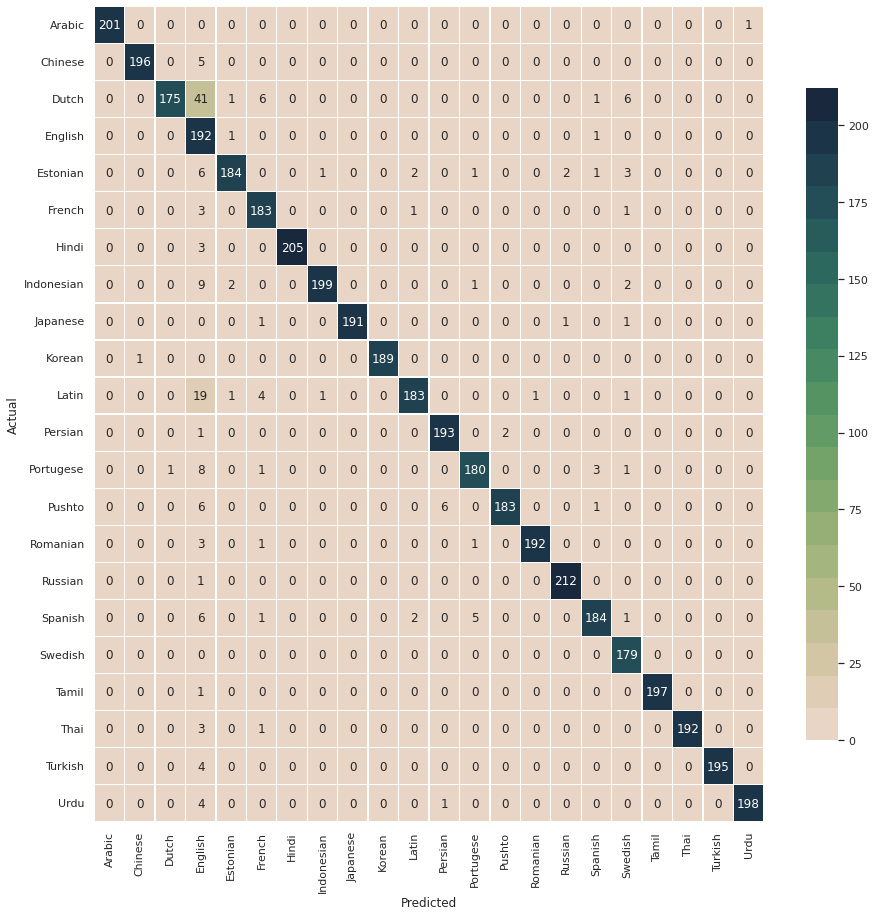

PCA and Explained Variance:
Variance explained by PCA: [0.3131436  0.13806745]


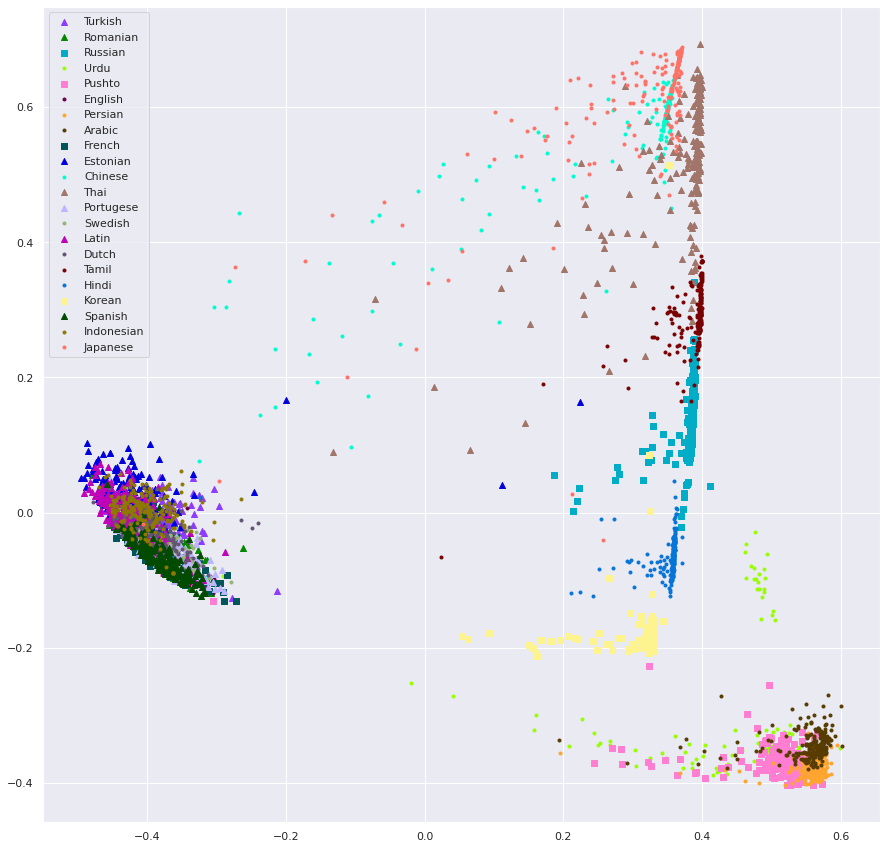

In [14]:
vocabulary = 1000
analyzer = 'char'
results(input, vocabulary, analyzer)

## Experiment 2: size of vocabulary 500

Since the classifier was so accurate with a vocabular size of 1000, we decided to test it with half the amount, and set the vocabulary size to 500 to see the changes.

The classifer makes very few mistakes identifying the language with a vocabulary size of 500 characters.

With 500 characters, the coverage is 0.96 and the F1 score is 0.96.
It was interesting to see that coverage only decreased by 0.02 and that the F1 score slighly improved by .005 with half the amount of characters as the previous experiment.

The language with the most mistakes is Dutch, which is incorrectly classifed as English 25 times.

Languages {'Turkish', 'Romanian', 'Russian', 'Urdu', 'Pushto', 'English', 'Persian', 'Arabic', 'French', 'Estonian', 'Chinese', 'Thai', 'Portugese', 'Swedish', 'Latin', 'Dutch', 'Tamil', 'Hindi', 'Korean', 'Spanish', 'Indonesian', 'Japanese'}
Split sizes:
Train: 17600
Test: 4400


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Number of tokens in the vocabulary: 500
Coverage:  0.960360956129256
Prediction Results:
F1: 0.9602272727272727 (micro), 0.9622050216794633 (macro), 0.9620524366626872 (weighted)


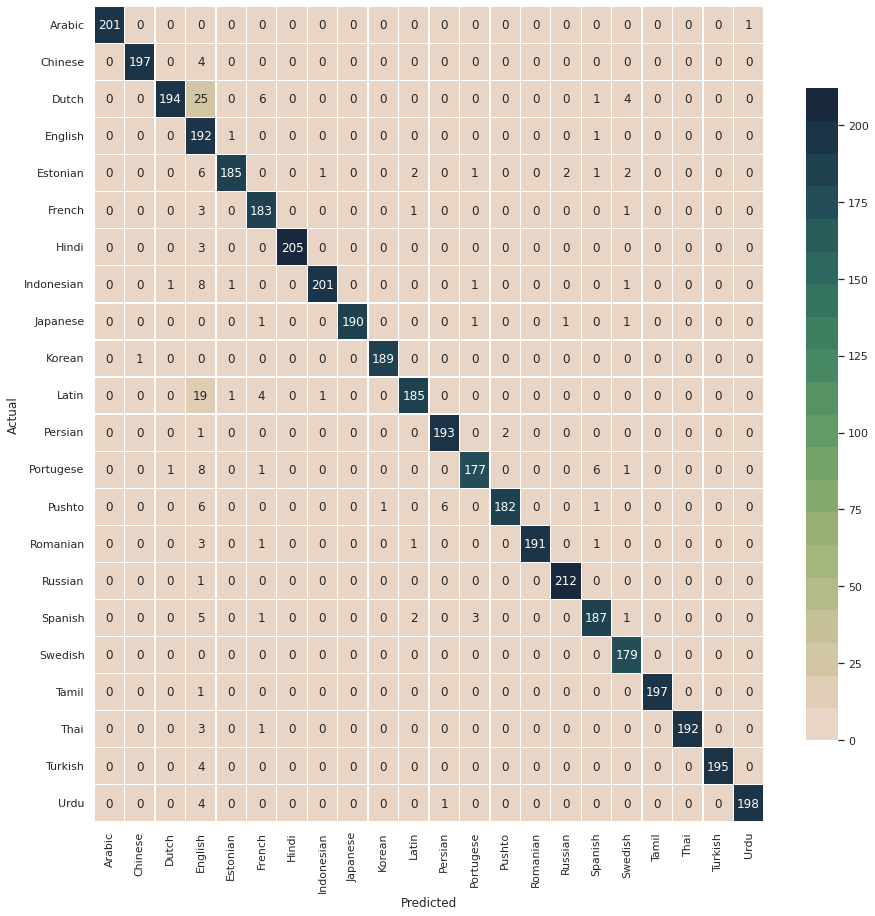

PCA and Explained Variance:
Variance explained by PCA: [0.31489875 0.14208597]


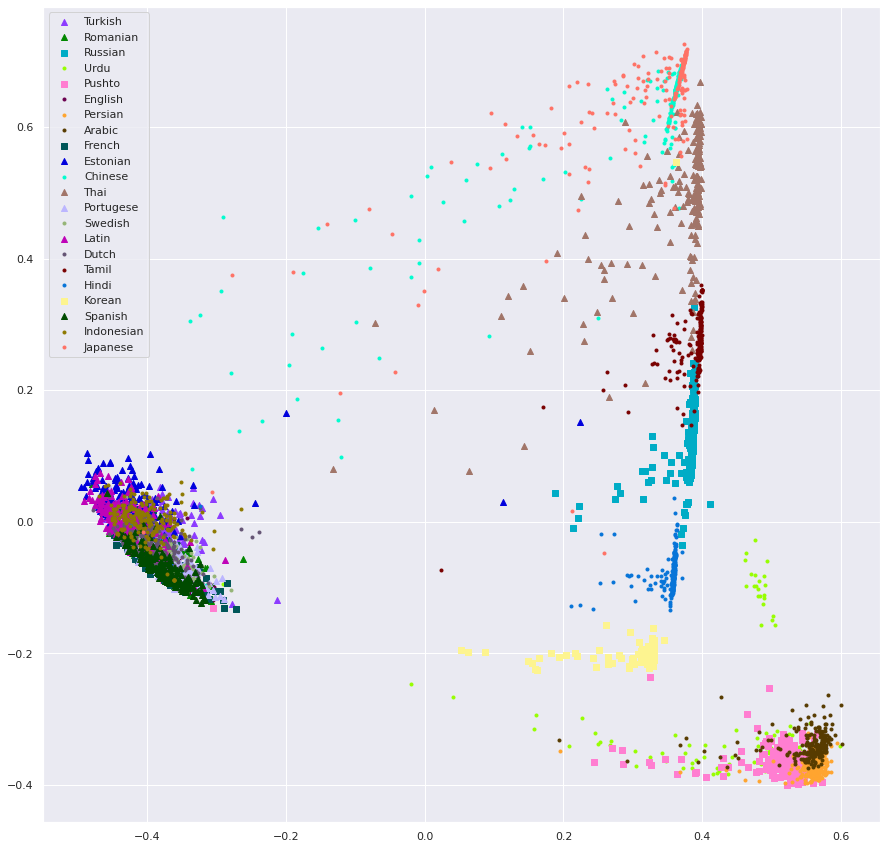

In [15]:
vocabulary = 500
analyzer = 'char'
results(input, vocabulary, analyzer)

## Experiment 3: size of vocabulary 26

Since the classifier was so accurate with a vocabulary size of 500 and 1000, we decided to test it with a much smaller amount. We chose 26 characters since many of the languages are based on the latin script which has 26 letters in the [ISO basic Latin alphabet](https://en.wikipedia.org/wiki/ISO_basic_Latin_alphabet).

It is likely that a mix of latin and arabic characters are included in the 26 most common characters, and we can see in the confusion matrix that many of the latin-based and arabic-based languages are identified correctly.

Even though Korean has a unique script, it has many correct classifications, so there is probably at least one Korean character in the vocabulary.

Alternatively, the other languages which have unique scripts such as Chinese, Hindi, Japanese, Russian, Tamil, and Thai have not been correctly identified. Due to the random seed, they are mistaken for Swedish, which is not for a linguistic reason.

With a vocabulary of size 26, we have coverage of .63 and an F1 score of .6.



Languages {'Turkish', 'Romanian', 'Russian', 'Urdu', 'Pushto', 'English', 'Persian', 'Arabic', 'French', 'Estonian', 'Chinese', 'Thai', 'Portugese', 'Swedish', 'Latin', 'Dutch', 'Tamil', 'Hindi', 'Korean', 'Spanish', 'Indonesian', 'Japanese'}
Split sizes:
Train: 17600
Test: 4400


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Number of tokens in the vocabulary: 26
Coverage:  0.6292508009476543
Prediction Results:
F1: 0.595 (micro), 0.5548961586288264 (macro), 0.5550344701845369 (weighted)


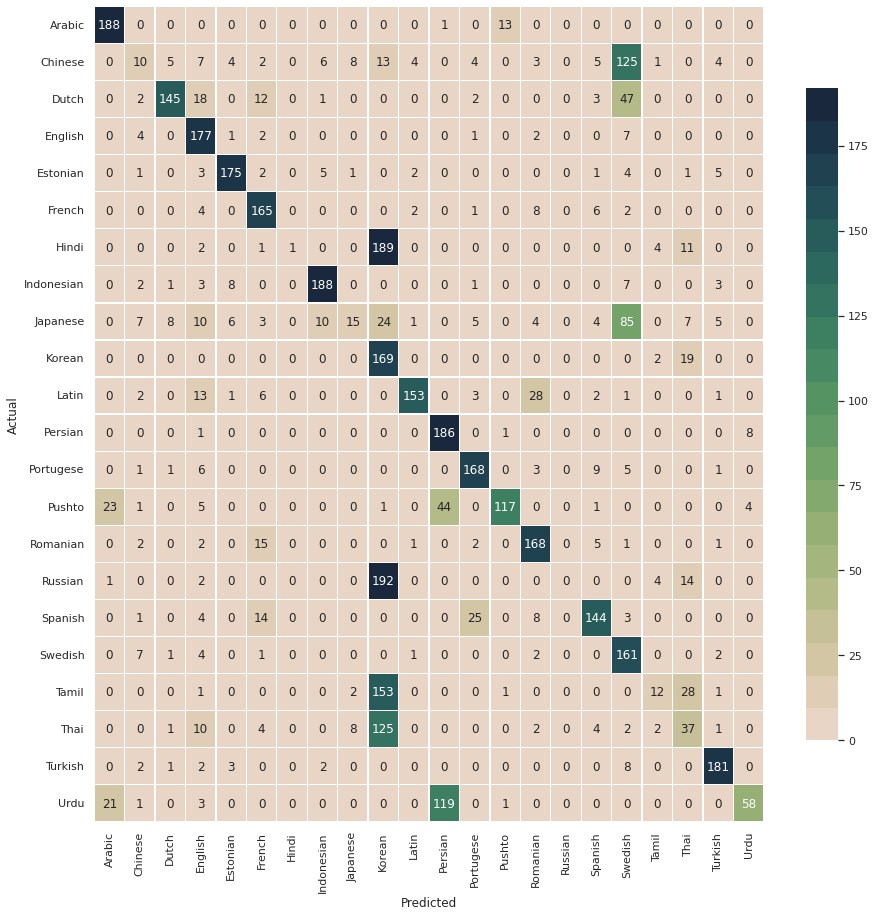

PCA and Explained Variance:
Variance explained by PCA: [0.53243244 0.1509213 ]


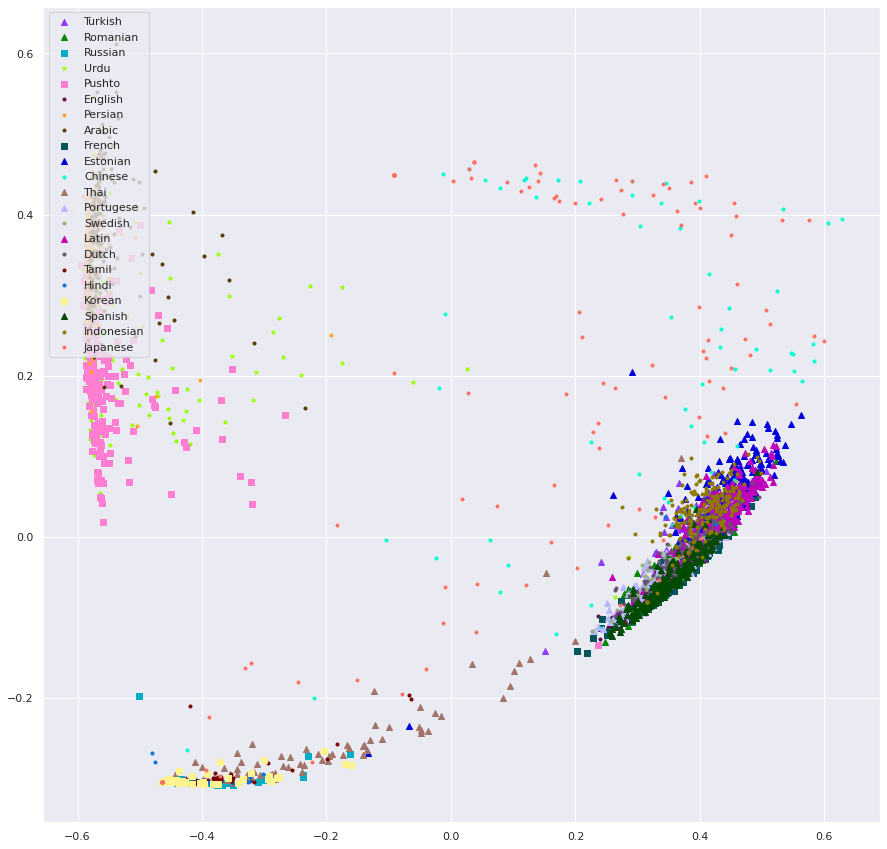

In [16]:
vocabulary = 26
analyzer = 'char'
results(input, vocabulary, analyzer)

## Experiment 4: size of vocabulary 54

Since the size of the Latin Script is 26 and the size of the Arabic script is 28, we decided to run an experiement with the most common 54 characters.

With a vocabulary of size 54, we have coverage of .74 and an F1 score of .82.

The prediction results for most of the languages with unique scripts has improved a lot. Chinese and Japanese are the exceptions with many errors, and due to the random seed are being mistaken for Swedish.

Languages {'Turkish', 'Romanian', 'Russian', 'Urdu', 'Pushto', 'English', 'Persian', 'Arabic', 'French', 'Estonian', 'Chinese', 'Thai', 'Portugese', 'Swedish', 'Latin', 'Dutch', 'Tamil', 'Hindi', 'Korean', 'Spanish', 'Indonesian', 'Japanese'}
Split sizes:
Train: 17600
Test: 4400


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Number of tokens in the vocabulary: 54
Coverage:  0.7447978530108569
Prediction Results:
F1: 0.8197727272727273 (micro), 0.7982147755967314 (macro), 0.8008252075655649 (weighted)


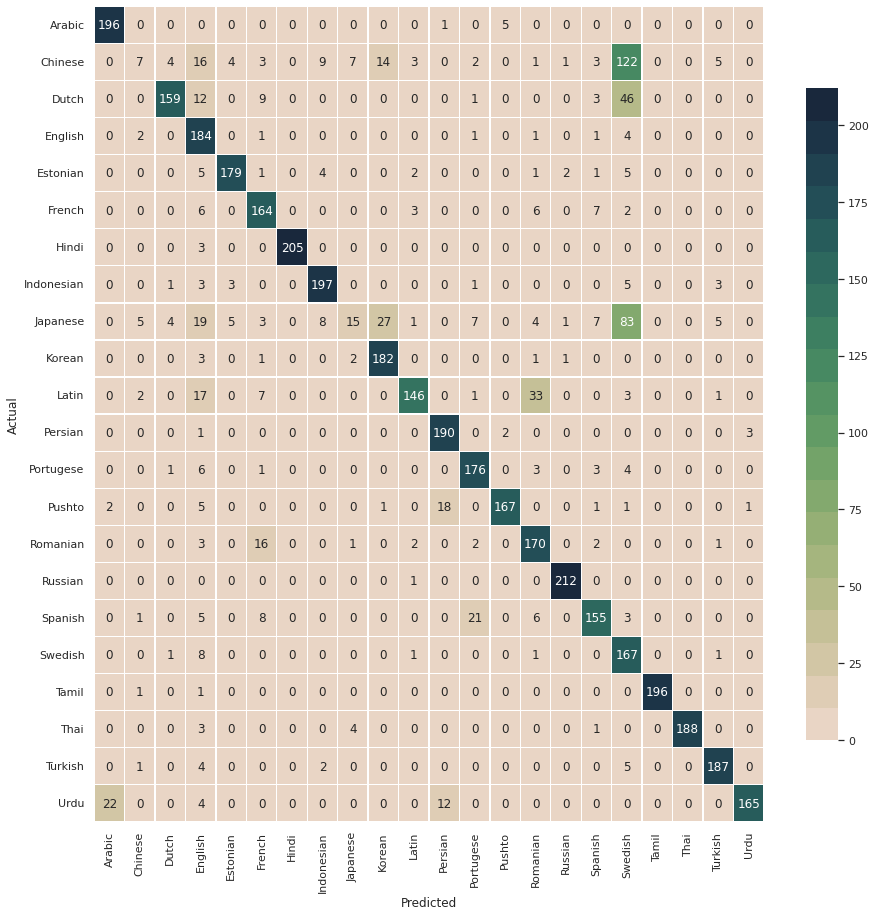

PCA and Explained Variance:
Variance explained by PCA: [0.39209465 0.12675722]


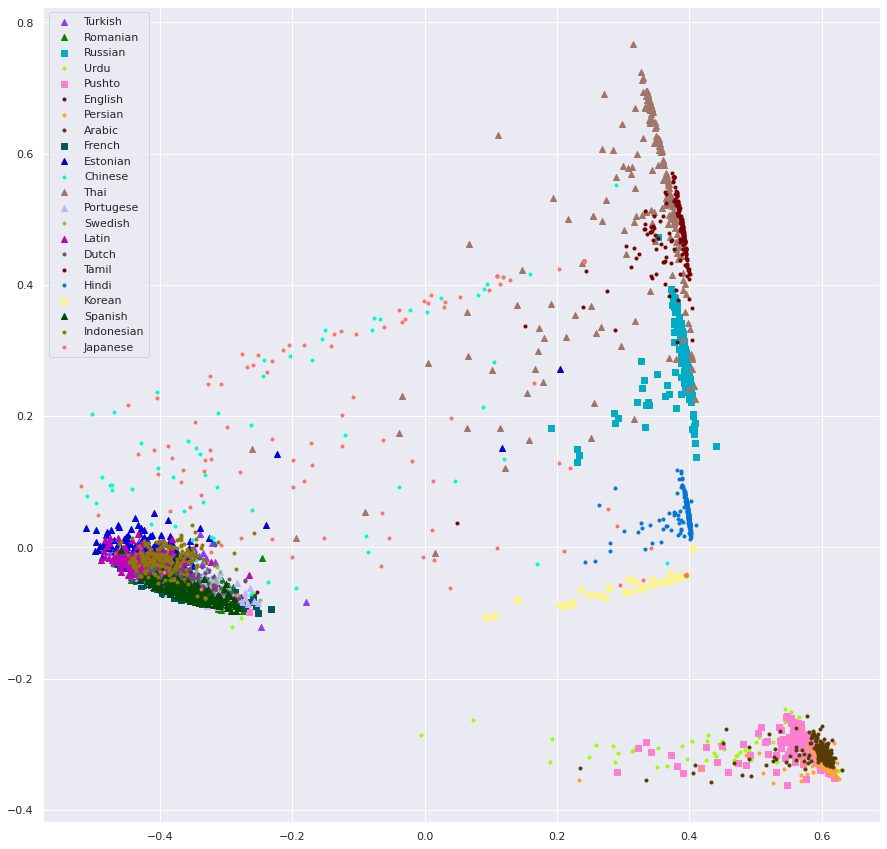

In [17]:
vocabulary = 54
analyzer = 'char'
results(input, vocabulary, analyzer)

## Experiment 4: size of vocabulary 100

With a vocabulary of size 100, we have coverage of .83 and an F1 score of .85.

Chinese and Japanese still have many classification errors.


Languages {'Turkish', 'Romanian', 'Russian', 'Urdu', 'Pushto', 'English', 'Persian', 'Arabic', 'French', 'Estonian', 'Chinese', 'Thai', 'Portugese', 'Swedish', 'Latin', 'Dutch', 'Tamil', 'Hindi', 'Korean', 'Spanish', 'Indonesian', 'Japanese'}
Split sizes:
Train: 17600
Test: 4400


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Number of tokens in the vocabulary: 100
Coverage:  0.827842160343621
Prediction Results:
F1: 0.8520454545454544 (micro), 0.8310957946818767 (macro), 0.833155291286102 (weighted)


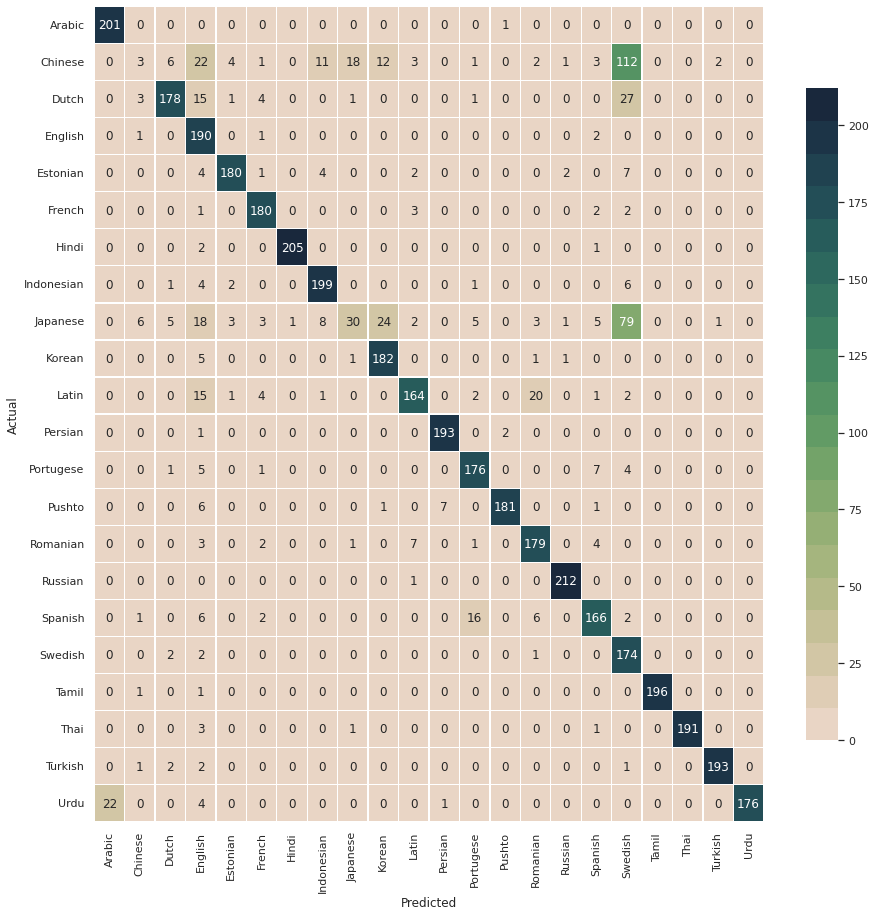

PCA and Explained Variance:
Variance explained by PCA: [0.36918363 0.13460385]


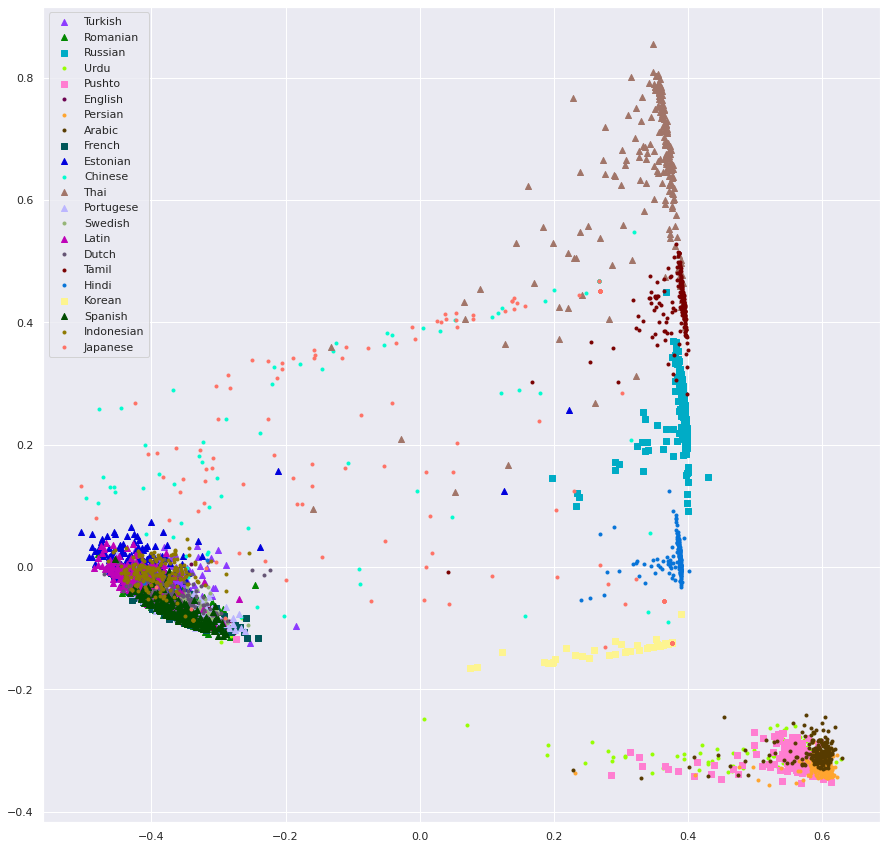

In [18]:
vocabulary = 100
analyzer = 'char'
results(input, vocabulary, analyzer)

## Experiment 5: size of vocabulary 112

Chinese classifications have improved alot once we increase the vocabulary size to 112, but there are still not many correct Japanese classifications.

With a vocabulary of size 112, we have coverage of .84 and an F1 score of .89.

Languages {'Turkish', 'Romanian', 'Russian', 'Urdu', 'Pushto', 'English', 'Persian', 'Arabic', 'French', 'Estonian', 'Chinese', 'Thai', 'Portugese', 'Swedish', 'Latin', 'Dutch', 'Tamil', 'Hindi', 'Korean', 'Spanish', 'Indonesian', 'Japanese'}
Split sizes:
Train: 17600
Test: 4400


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Number of tokens in the vocabulary: 112
Coverage:  0.8425847335203817
Prediction Results:
F1: 0.8909090909090909 (micro), 0.8881732942586787 (macro), 0.8888344115152913 (weighted)


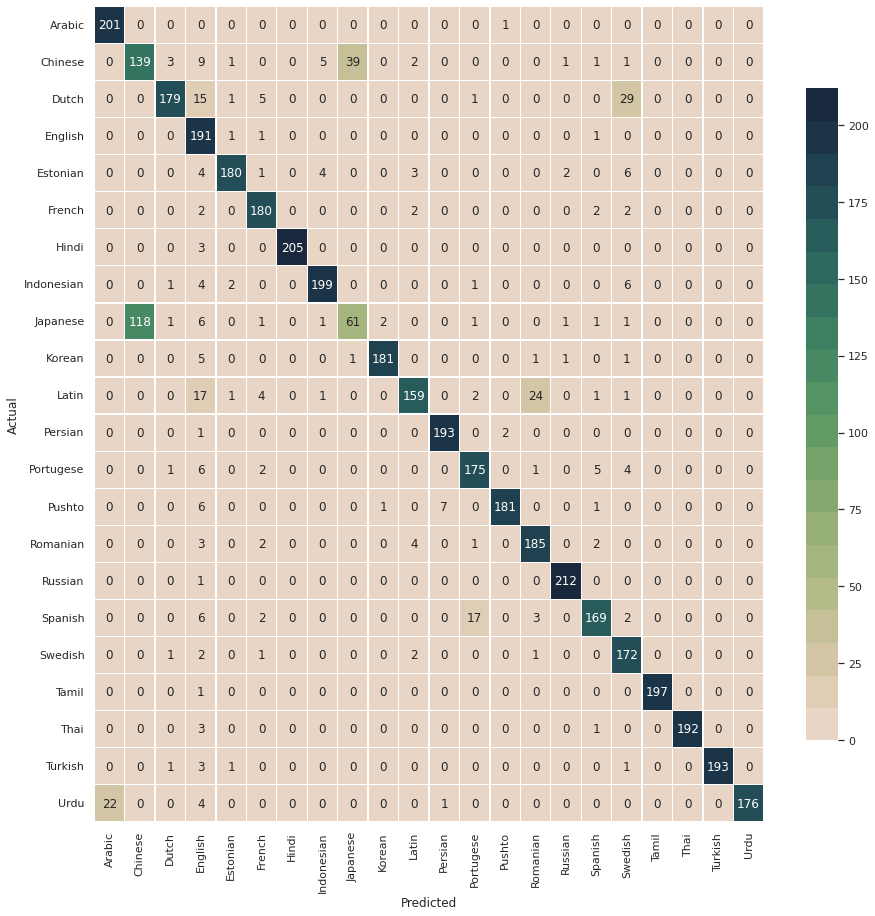

PCA and Explained Variance:
Variance explained by PCA: [0.3369045  0.17902927]


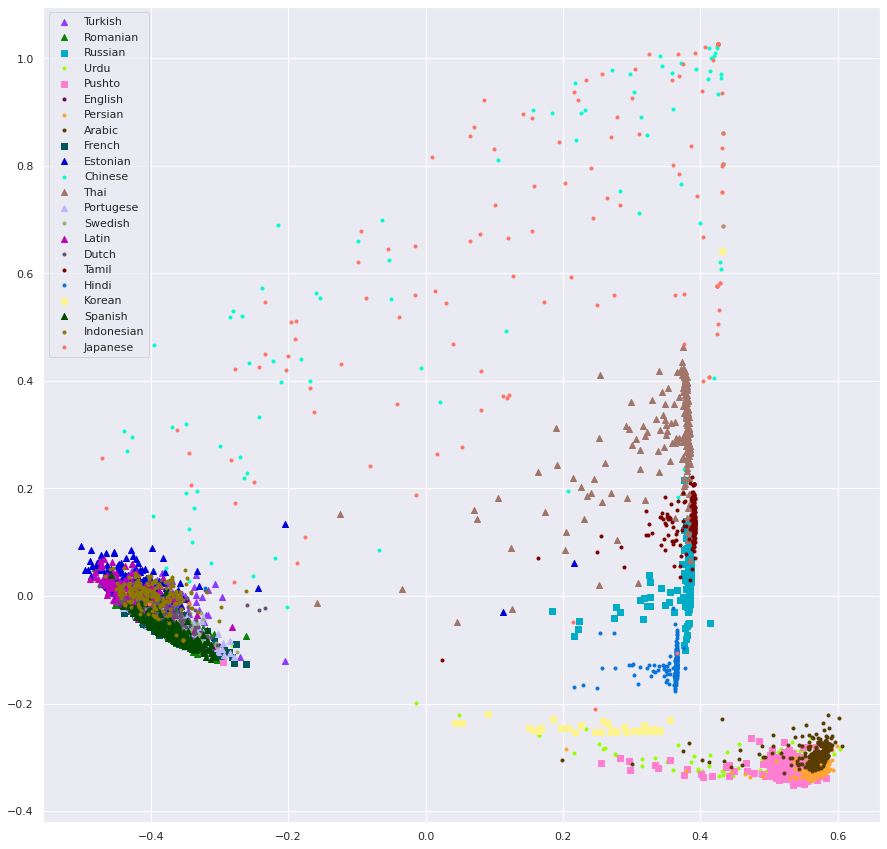

In [19]:
vocabulary = 112
analyzer = 'char'
results(input, vocabulary, analyzer)

## Experiment 6: size of vocabulary 113

All of the languages have many correct classifications once we have the vocabulary size at 113 characters.

With a vocabulary of size 113, we have coverage of .84 and an F1 score of .93.

Languages {'Portugese', 'Indonesian', 'Tamil', 'Korean', 'Estonian', 'Persian', 'French', 'Turkish', 'Thai', 'Pushto', 'Dutch', 'Hindi', 'Spanish', 'Latin', 'Russian', 'Arabic', 'Japanese', 'Romanian', 'Urdu', 'Chinese', 'Swedish', 'English'}
Split sizes:
Train: 17600
Test: 4400


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Number of tokens in the vocabulary: 113
Coverage:  0.8437185800594531
Prediction Results:
F1: 0.9290909090909091 (micro), 0.9303929033193417 (macro), 0.9304499444500807 (weighted)


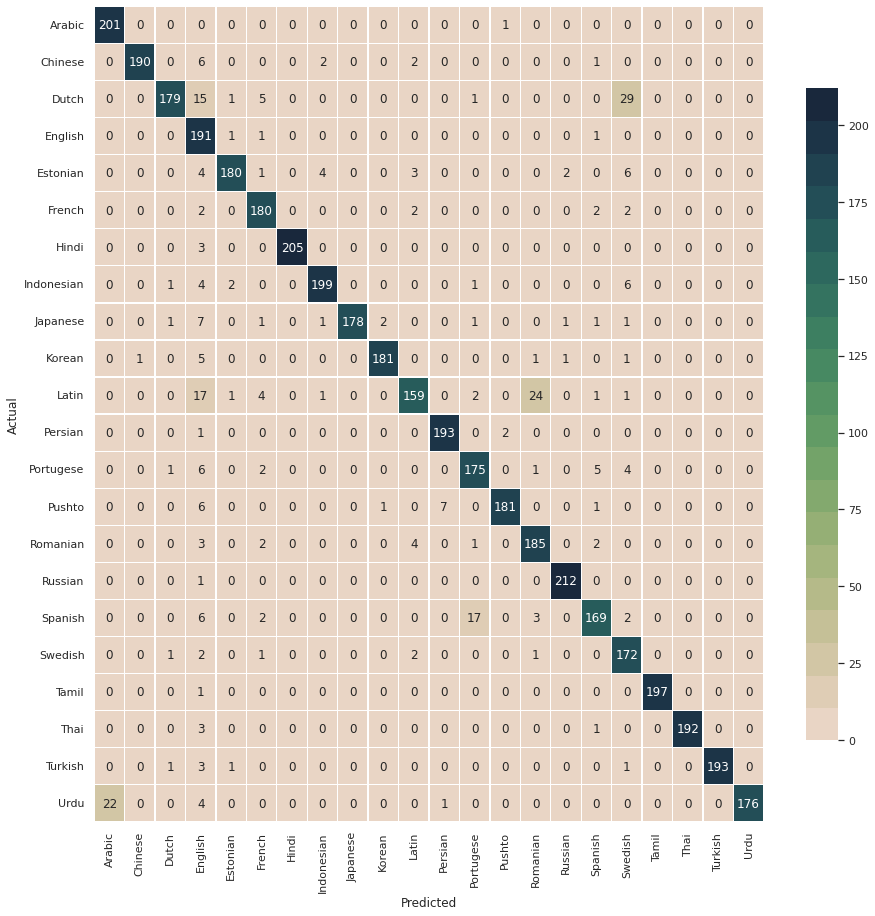

PCA and Explained Variance:
Variance explained by PCA: [0.33275575 0.16285624]


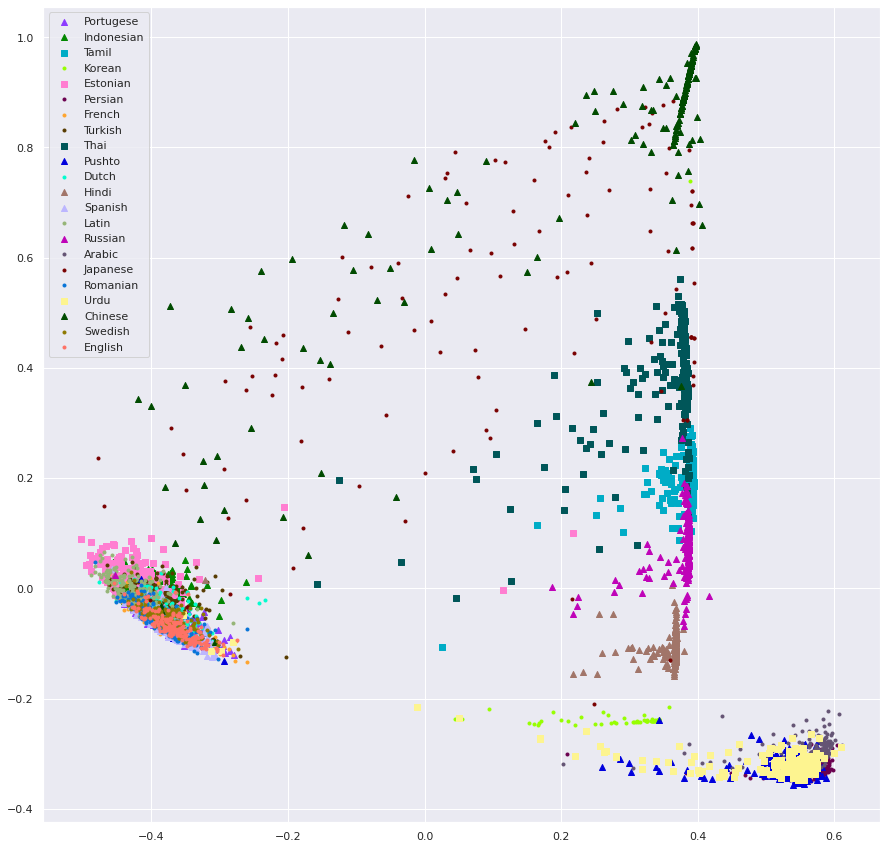

In [ ]:
vocabulary = 113
analyzer = 'char'
results(input, vocabulary, analyzer)

## Experiment 7: size of vocabulary 150

With a vocabulary of size 150, we have coverage of .88 and an F1 score of .95, which is similar to the F1 score when the vocabulary size was 1000.

It seems that we don't need close to 100% coverage in order to obtain very good classification results. Increasing the coverage of the vocabulary at some point does not yield a similar increase in the classification accuracy.

Languages {'Turkish', 'Romanian', 'Russian', 'Urdu', 'Pushto', 'English', 'Persian', 'Arabic', 'French', 'Estonian', 'Chinese', 'Thai', 'Portugese', 'Swedish', 'Latin', 'Dutch', 'Tamil', 'Hindi', 'Korean', 'Spanish', 'Indonesian', 'Japanese'}
Split sizes:
Train: 17600
Test: 4400


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Number of tokens in the vocabulary: 150
Coverage:  0.8780710483907213
Prediction Results:
F1: 0.9461363636363637 (micro), 0.9478075327237989 (macro), 0.9479221788589296 (weighted)


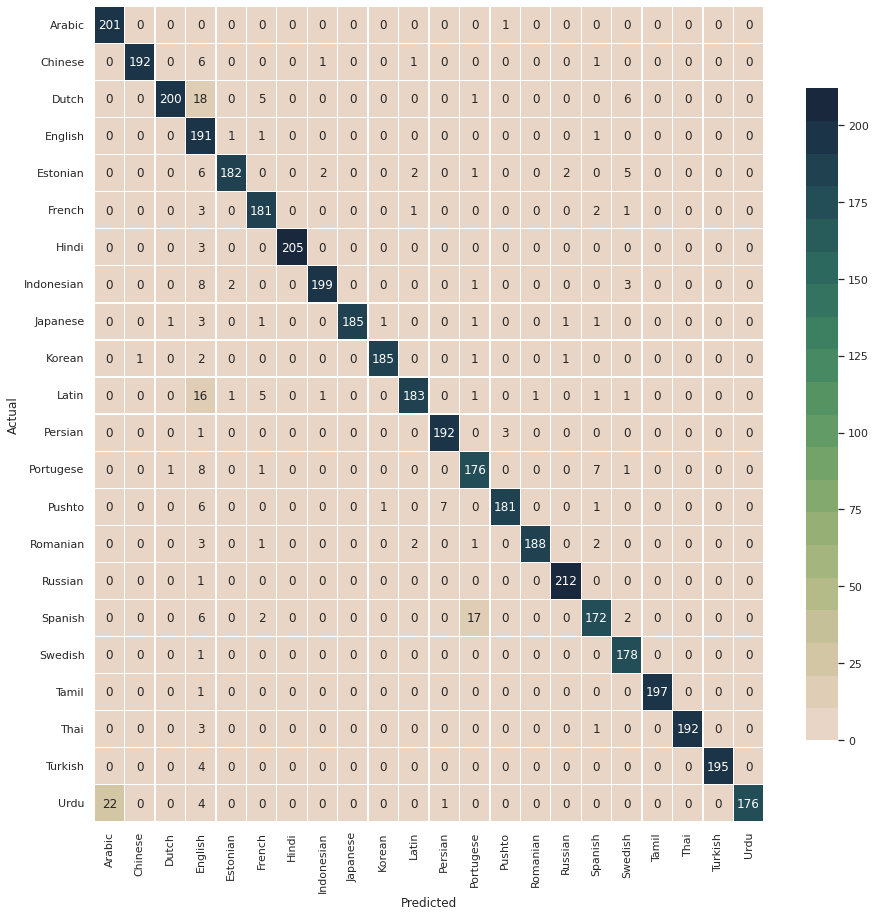

PCA and Explained Variance:
Variance explained by PCA: [0.32532436 0.15686538]


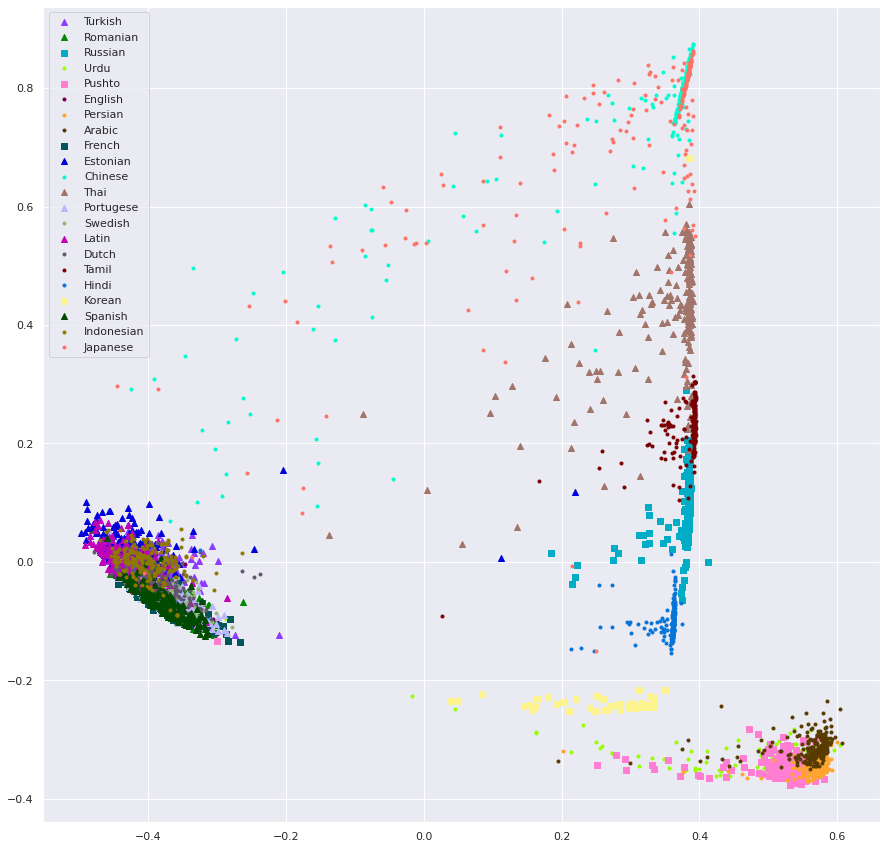

In [20]:
vocabulary = 150
analyzer = 'char'
results(input, vocabulary, analyzer)

# Tokenizing with words

## Experiment 1: size of vocabulary 1,000

Languages {'Turkish', 'Romanian', 'Russian', 'Urdu', 'Pushto', 'English', 'Persian', 'Arabic', 'French', 'Estonian', 'Chinese', 'Thai', 'Portugese', 'Swedish', 'Latin', 'Dutch', 'Tamil', 'Hindi', 'Korean', 'Spanish', 'Indonesian', 'Japanese'}
Split sizes:
Train: 17600
Test: 4400


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Number of tokens in the vocabulary: 1000
Coverage:  0.25771498027437495
Prediction Results:
F1: 0.8920454545454546 (micro), 0.881225725511312 (macro), 0.8845797399266582 (weighted)


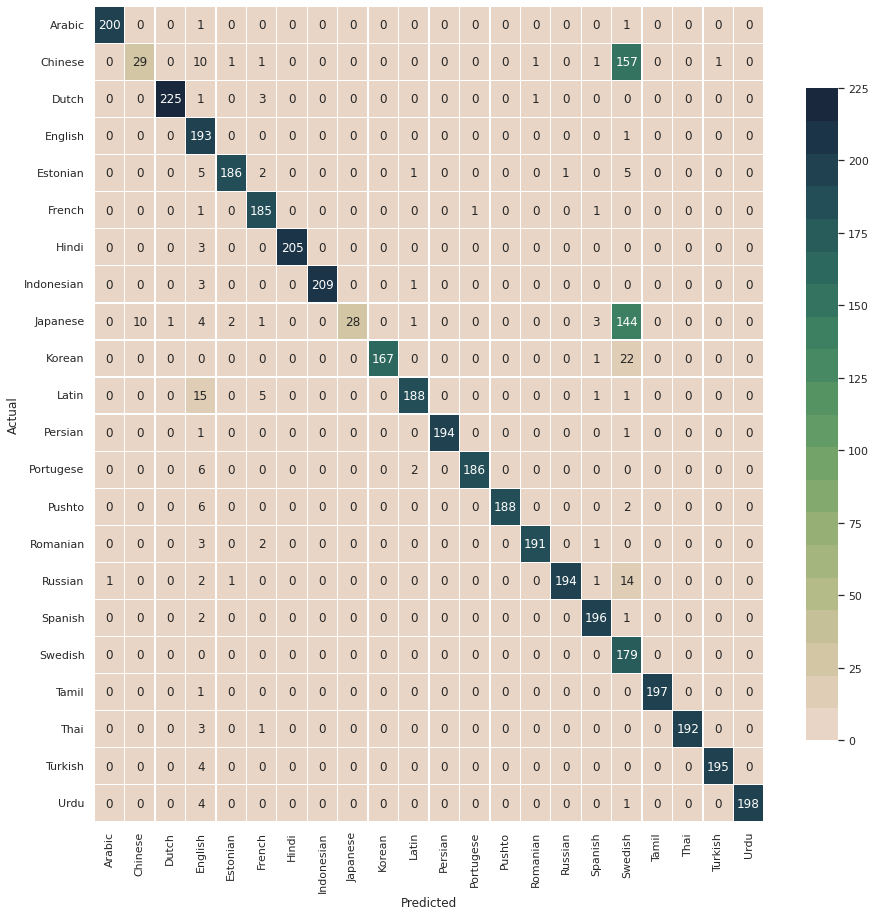

PCA and Explained Variance:
Variance explained by PCA: [0.07878438 0.03638187]


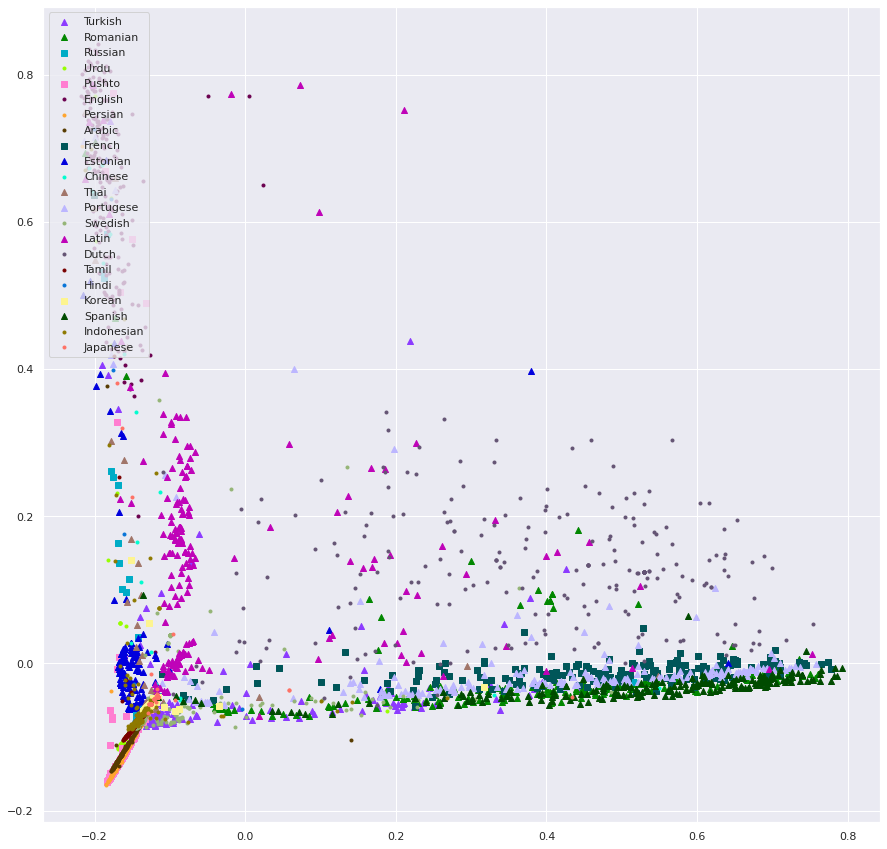

In [21]:
vocabulary = 1000
analyzer = 'word'
results(input, vocabulary, analyzer)

## Experiment : vocabulary size 2,000

Languages {'Turkish', 'Romanian', 'Russian', 'Urdu', 'Pushto', 'English', 'Persian', 'Arabic', 'French', 'Estonian', 'Chinese', 'Thai', 'Portugese', 'Swedish', 'Latin', 'Dutch', 'Tamil', 'Hindi', 'Korean', 'Spanish', 'Indonesian', 'Japanese'}
Split sizes:
Train: 17600
Test: 4400


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Number of tokens in the vocabulary: 2000
Coverage:  0.30266285567313955
Prediction Results:
F1: 0.9034090909090909 (micro), 0.8952733711907622 (macro), 0.89824330473188 (weighted)


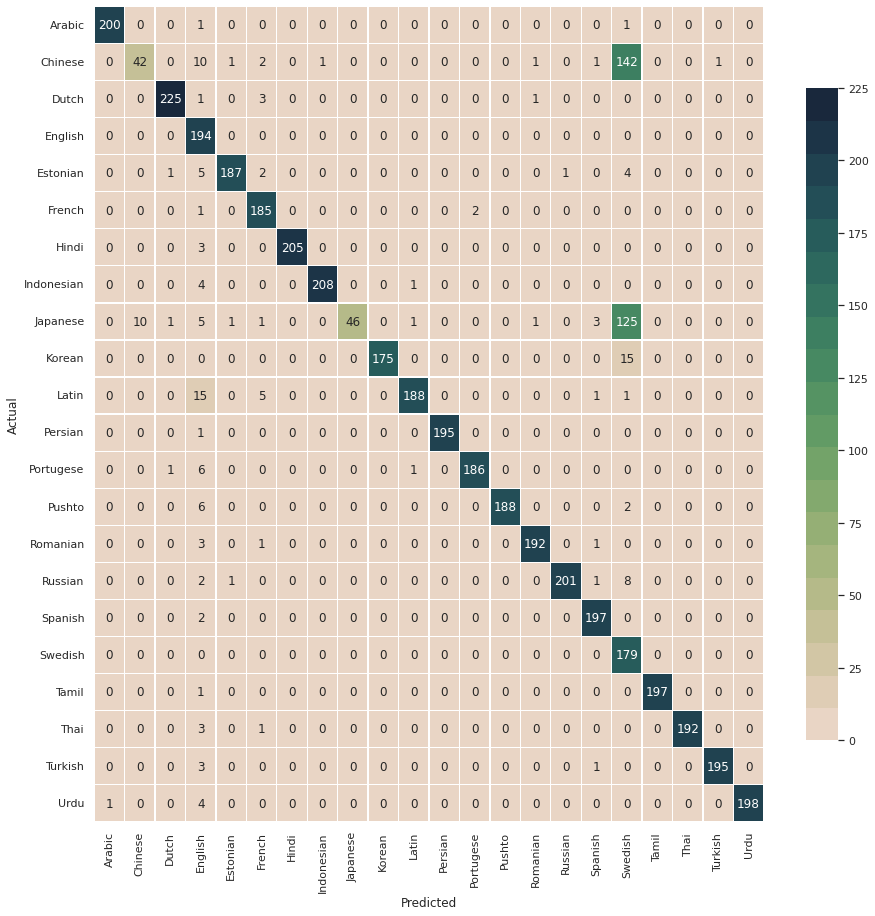

PCA and Explained Variance:
Variance explained by PCA: [0.07229505 0.0324767 ]


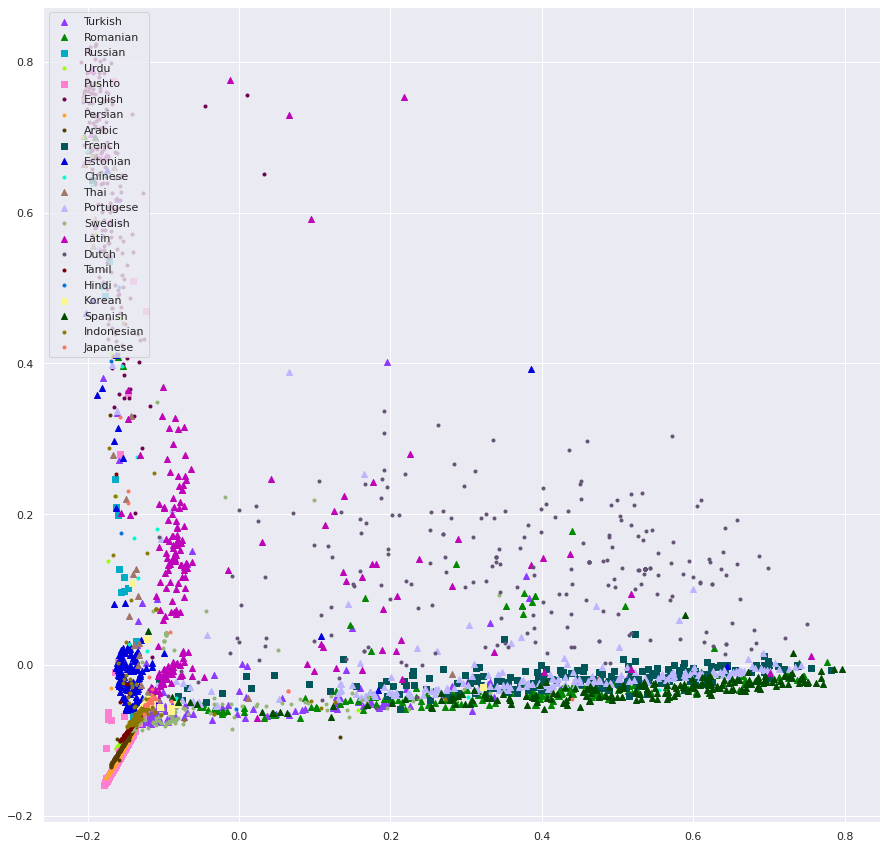

In [22]:
vocabulary = 2000
analyzer = 'word'
results(input, vocabulary, analyzer)

## Experiment : vocabulary size 500


Languages {'Turkish', 'Romanian', 'Russian', 'Urdu', 'Pushto', 'English', 'Persian', 'Arabic', 'French', 'Estonian', 'Chinese', 'Thai', 'Portugese', 'Swedish', 'Latin', 'Dutch', 'Tamil', 'Hindi', 'Korean', 'Spanish', 'Indonesian', 'Japanese'}
Split sizes:
Train: 17600
Test: 4400


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Number of tokens in the vocabulary: 500
Coverage:  0.21844625959835226
Prediction Results:
F1: 0.8634090909090909 (micro), 0.8511477449515699 (macro), 0.8556316226612983 (weighted)


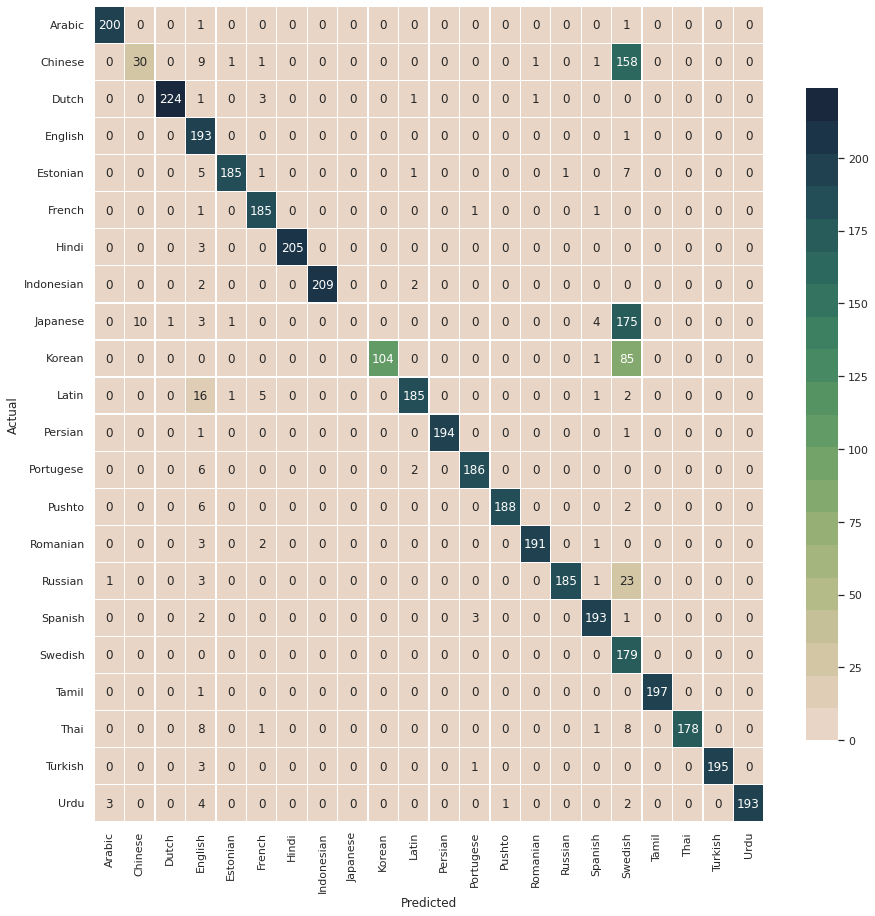

PCA and Explained Variance:
Variance explained by PCA: [0.08693102 0.04166859]


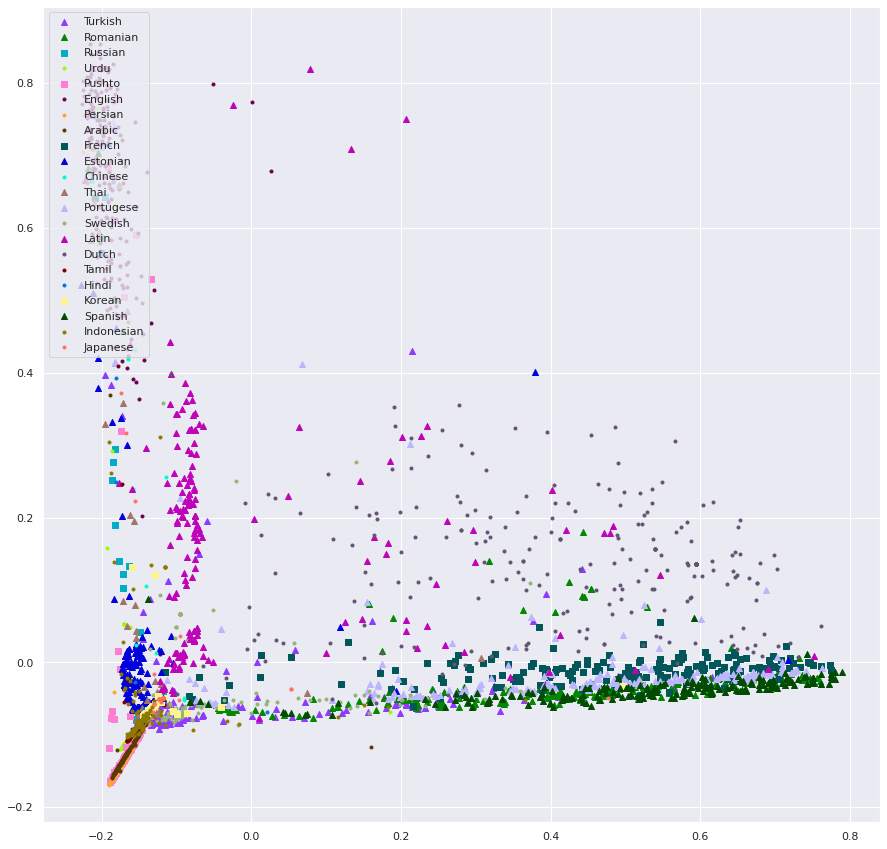

In [24]:
vocabulary = 500
analyzer = 'word'
results(input, vocabulary, analyzer)

## Experiment : vocabulary size 250


Languages {'Turkish', 'Romanian', 'Russian', 'Urdu', 'Pushto', 'English', 'Persian', 'Arabic', 'French', 'Estonian', 'Chinese', 'Thai', 'Portugese', 'Swedish', 'Latin', 'Dutch', 'Tamil', 'Hindi', 'Korean', 'Spanish', 'Indonesian', 'Japanese'}
Split sizes:
Train: 17600
Test: 4400


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Number of tokens in the vocabulary: 250
Coverage:  0.18493966157381864
Prediction Results:
F1: 0.8231818181818181 (micro), 0.811434567024742 (macro), 0.8164754451511239 (weighted)


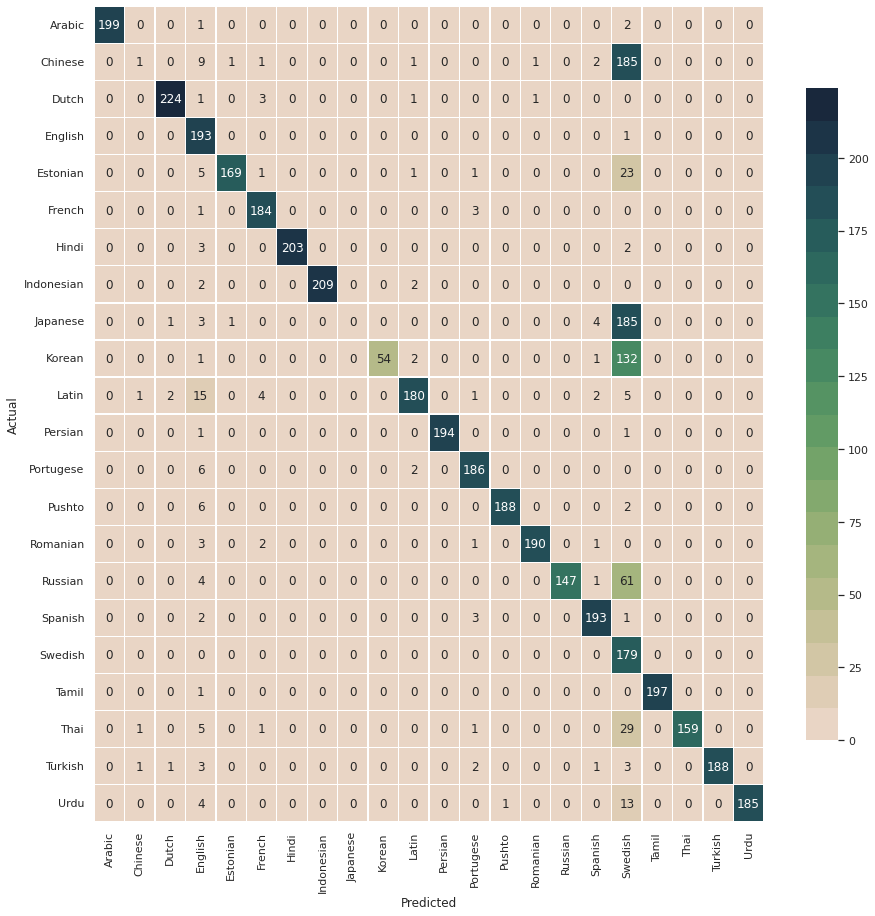

PCA and Explained Variance:
Variance explained by PCA: [0.09611463 0.04739089]


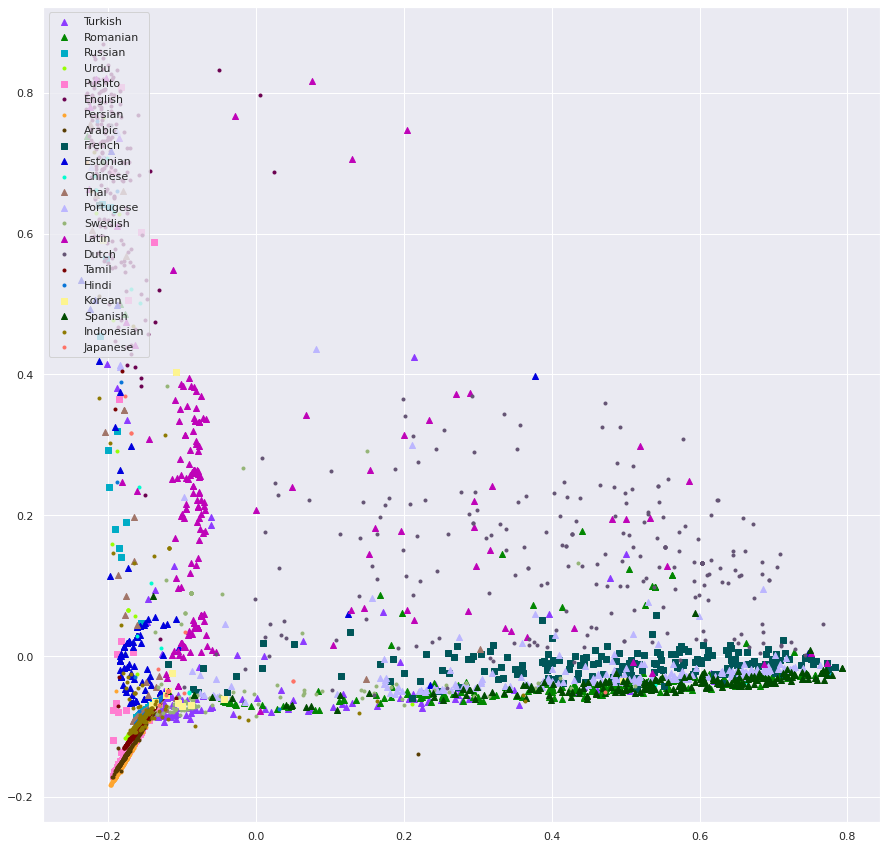

In [25]:
vocabulary = 250
analyzer = 'word'
results(input, vocabulary, analyzer)

## Experiment : vocabulary size 50


Languages {'Turkish', 'Romanian', 'Russian', 'Urdu', 'Pushto', 'English', 'Persian', 'Arabic', 'French', 'Estonian', 'Chinese', 'Thai', 'Portugese', 'Swedish', 'Latin', 'Dutch', 'Tamil', 'Hindi', 'Korean', 'Spanish', 'Indonesian', 'Japanese'}
Split sizes:
Train: 17600
Test: 4400


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Number of tokens in the vocabulary: 50
Coverage:  0.10632340068946348
Prediction Results:
F1: 0.6868181818181818 (micro), 0.6704931370406388 (macro), 0.6752019772301222 (weighted)


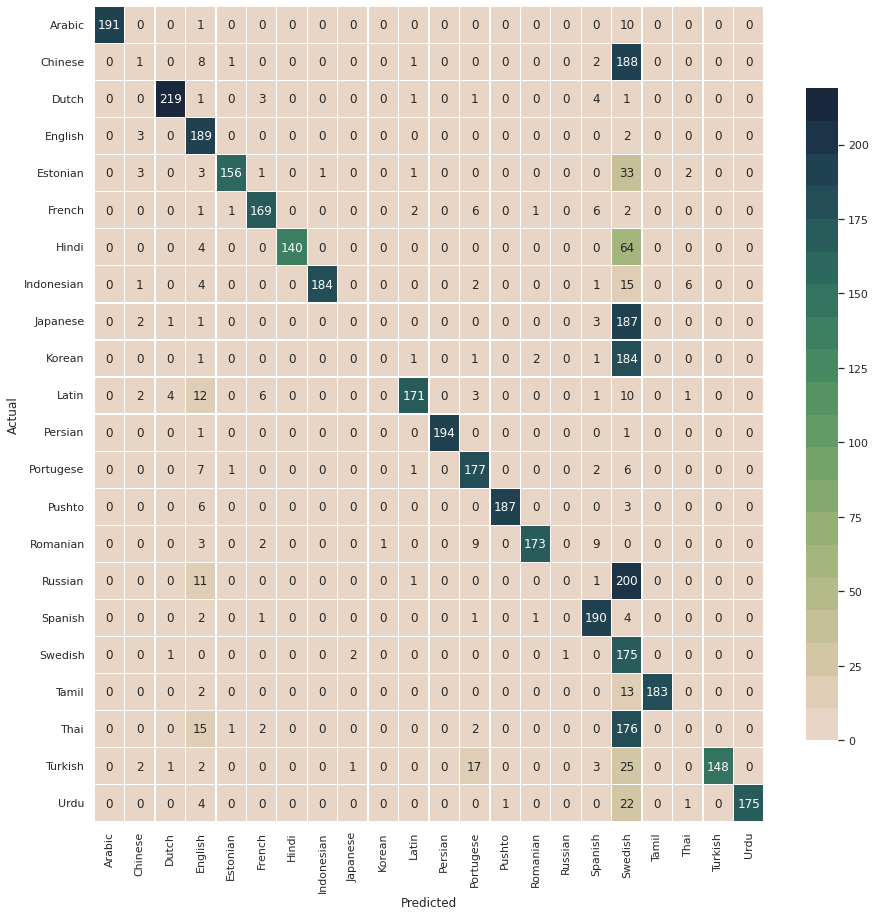

PCA and Explained Variance:
Variance explained by PCA: [0.1529902  0.06745393]


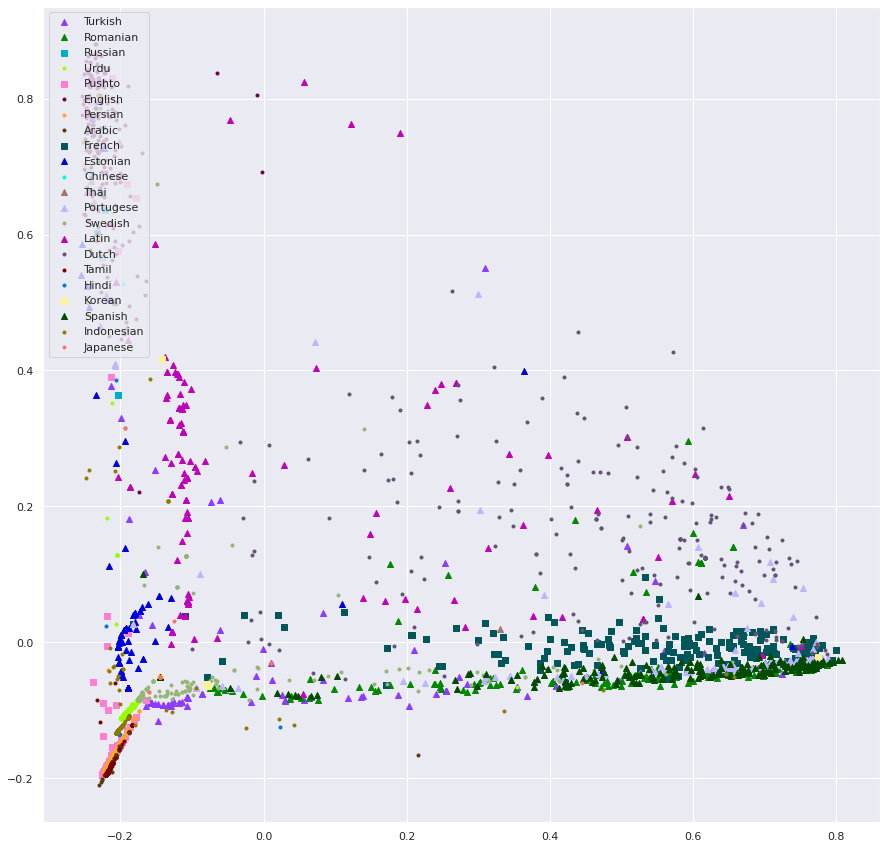

In [26]:
vocabulary = 50
analyzer = 'word'
results(input, vocabulary, analyzer)

## Experiment : vocabulary size 10,000

This experiment took approximately 1 minute to complete.

Languages {'Turkish', 'Romanian', 'Russian', 'Urdu', 'Pushto', 'English', 'Persian', 'Arabic', 'French', 'Estonian', 'Chinese', 'Thai', 'Portugese', 'Swedish', 'Latin', 'Dutch', 'Tamil', 'Hindi', 'Korean', 'Spanish', 'Indonesian', 'Japanese'}
Split sizes:
Train: 17600
Test: 4400


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Number of tokens in the vocabulary: 10000
Coverage:  0.43612506585579347
Prediction Results:
F1: 0.9154545454545454 (micro), 0.9073728866705114 (macro), 0.9099678530595126 (weighted)


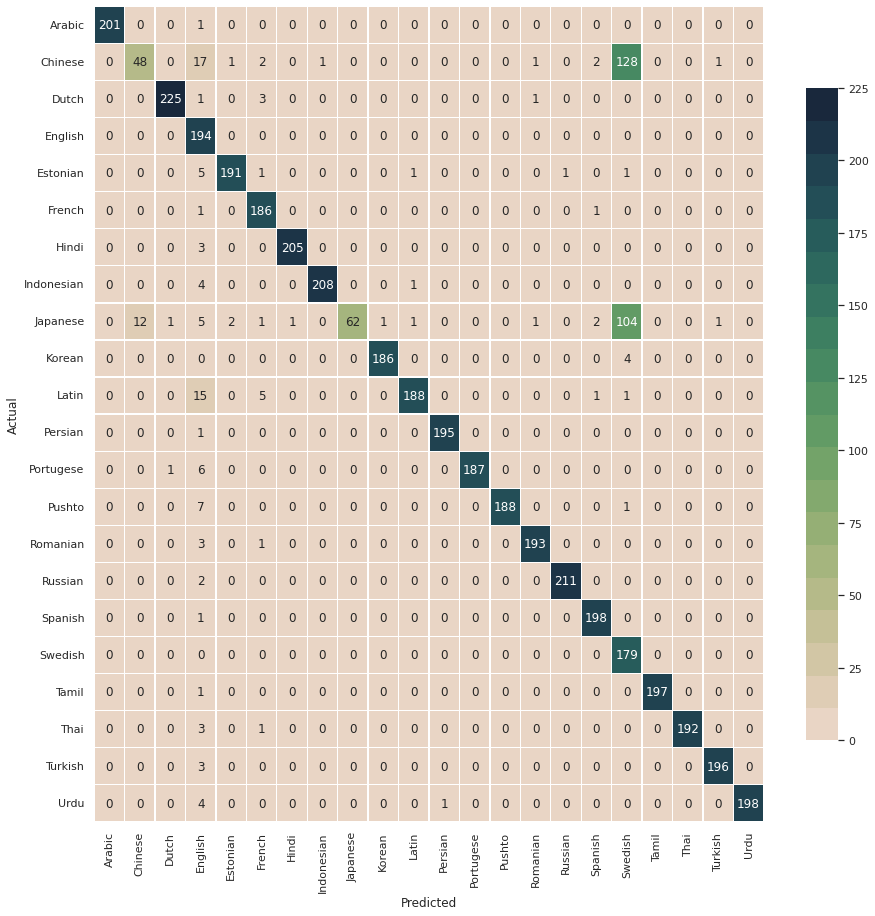

PCA and Explained Variance:
Variance explained by PCA: [0.05864405 0.02522936]


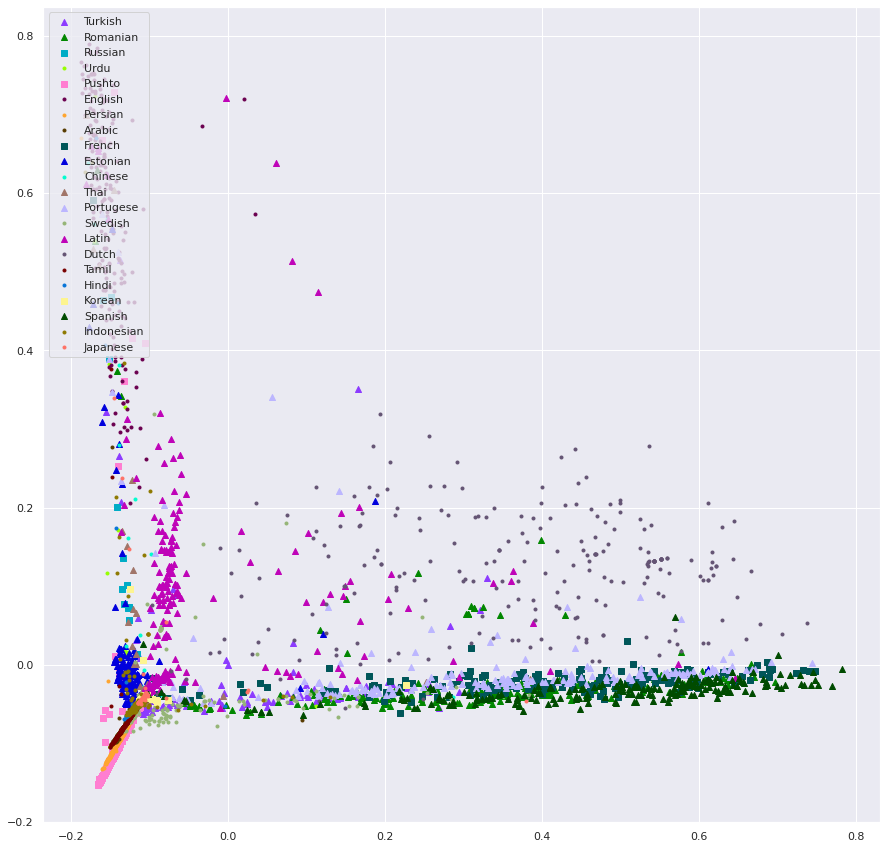

In [27]:
vocabulary = 10000
analyzer = 'word'
results(input, vocabulary, analyzer)

This experiment took 2 minutes to complete.

Languages {'Turkish', 'Romanian', 'Russian', 'Urdu', 'Pushto', 'English', 'Persian', 'Arabic', 'French', 'Estonian', 'Chinese', 'Thai', 'Portugese', 'Swedish', 'Latin', 'Dutch', 'Tamil', 'Hindi', 'Korean', 'Spanish', 'Indonesian', 'Japanese'}
Split sizes:
Train: 17600
Test: 4400


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Number of tokens in the vocabulary: 20000
Coverage:  0.4964220080727795
Prediction Results:
F1: 0.9215909090909091 (micro), 0.9153866291906414 (macro), 0.9177167132742569 (weighted)


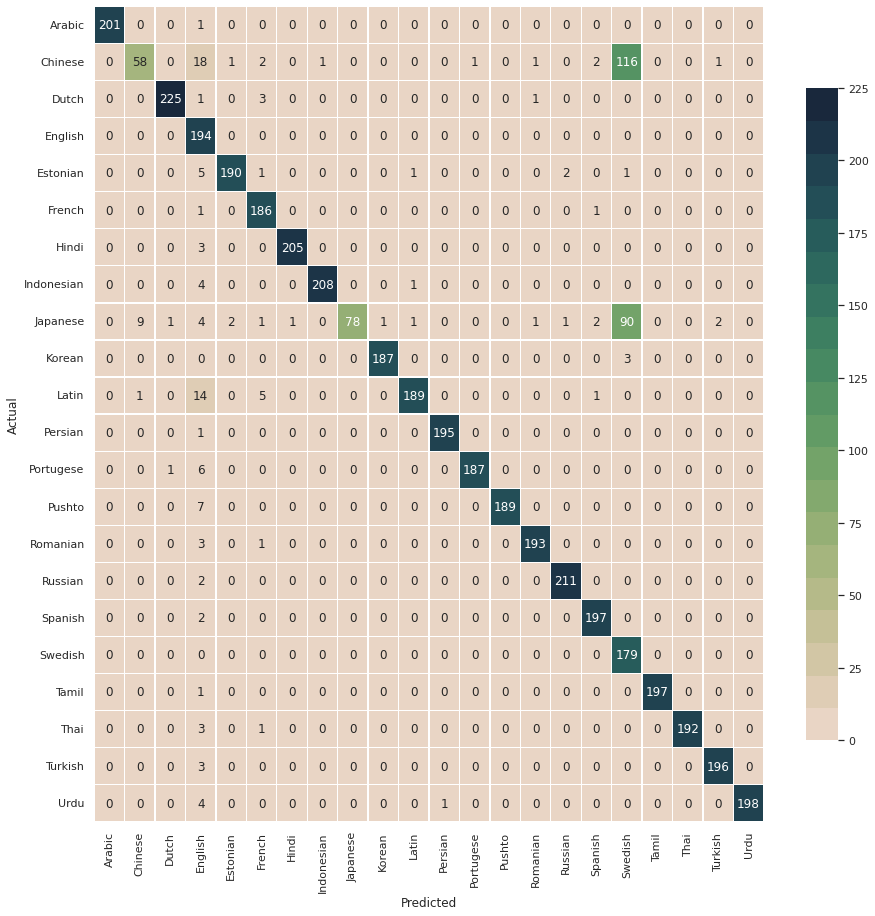

PCA and Explained Variance:
Variance explained by PCA: [0.05335276 0.02291198]


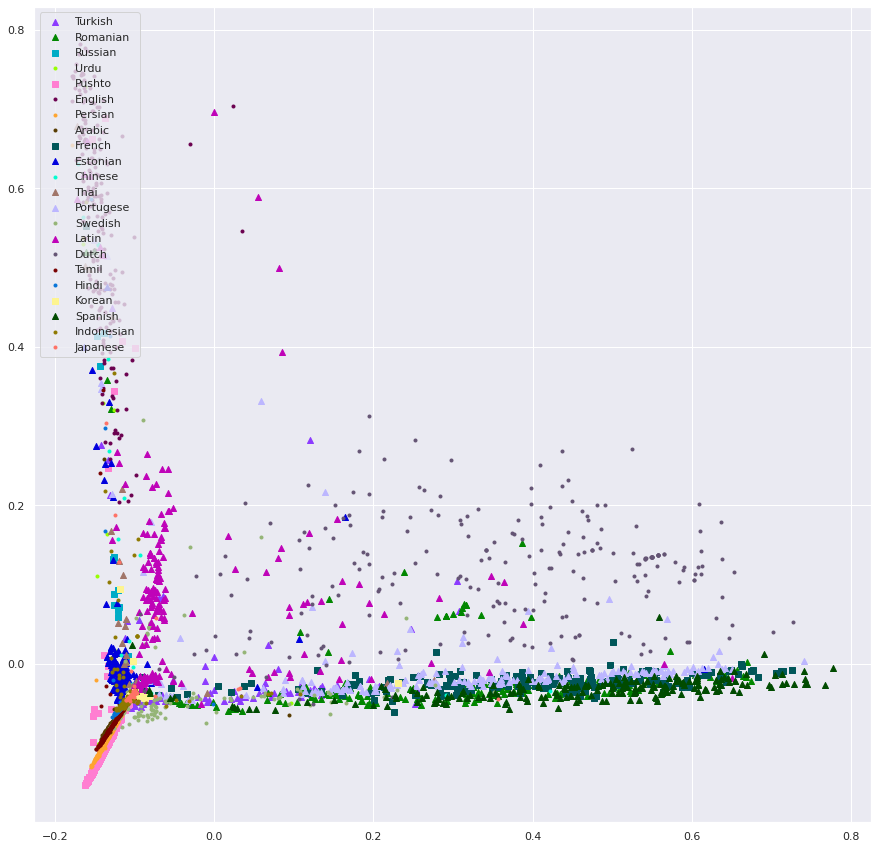

In [29]:
vocabulary = 20000
analyzer = 'word'
results(input, vocabulary, analyzer)

In [ ]:
# What is this code doing?
data['Text'].head()
s = ' '.join(data['Text'])
s2 = re.sub(r'[^\w\s]', '', s)
print(len(s2))
s3 = re.sub(r'\b(\w+)( \1\b)+', r'\1', s2)
print(len(s3))

7424781
7421026


In [ ]:
vocabulary = 7000000 # Number of distinct words in the concatenated string of the rows
analyzer = 'word'
results(input, vocabulary, analyzer)

Languages {'Portugese', 'Indonesian', 'Tamil', 'Korean', 'Estonian', 'Persian', 'French', 'Turkish', 'Thai', 'Pushto', 'Dutch', 'Hindi', 'Spanish', 'Latin', 'Russian', 'Arabic', 'Japanese', 'Romanian', 'Urdu', 'Chinese', 'Swedish', 'English'}
Split sizes:
Train: 17600
Test: 4400


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Number of tokens in the vocabulary: 238293


KeyboardInterrupt: ignored

In [ ]:
# https://en.wikipedia.org/wiki/List_of_dictionaries_by_number_of_words
vocabulary = 7000000 # number of words in korean language 
analyzer = 'word'
results(input, vocabulary, analyzer)

Languages {'Portugese', 'Indonesian', 'Tamil', 'Korean', 'Estonian', 'Persian', 'French', 'Turkish', 'Thai', 'Pushto', 'Dutch', 'Hindi', 'Spanish', 'Latin', 'Russian', 'Arabic', 'Japanese', 'Romanian', 'Urdu', 'Chinese', 'Swedish', 'English'}
Split sizes:
Train: 17600
Test: 4400


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Number of tokens in the vocabulary: 238293


KeyboardInterrupt: ignored

In [ ]:
vocabulary = 7000000
analyzer = 'word'
results(input, vocabulary, analyzer)

In [ ]:
vocabulary = 500000 # aprox number of words in italian, japanese, english, dutch 
analyzer = 'word'
results(input, vocabulary, analyzer)

In [ ]:
vocabulary = 380000 # number of words in chinese language 
analyzer = 'word'
results(input, vocabulary, analyzer)

In [ ]:
vocabulary = 300000 # aprox number of words in italian, japanese, english, dutch 
analyzer = 'word'
results(input, vocabulary, analyzer)

In [ ]:
vocabulary = 150000 # aprox number of words in polish, french, indonesian
analyzer = 'word'
results(input, vocabulary, analyzer)

In [23]:
vocabulary = 90000 # aprox number of words in spanish
analyzer = 'word'
results(input, vocabulary, analyzer)

Languages {'Turkish', 'Romanian', 'Russian', 'Urdu', 'Pushto', 'English', 'Persian', 'Arabic', 'French', 'Estonian', 'Chinese', 'Thai', 'Portugese', 'Swedish', 'Latin', 'Dutch', 'Tamil', 'Hindi', 'Korean', 'Spanish', 'Indonesian', 'Japanese'}
Split sizes:
Train: 17600
Test: 4400


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Number of tokens in the vocabulary: 90000


KeyboardInterrupt: ignored

**-How well does the vocabulary covers the data?**

Depending on the token (char, word) the size of the vocabulary presents distinct results. The next graph illustrates the changes in coverage per char and word tokenization using different size of vocabulary.

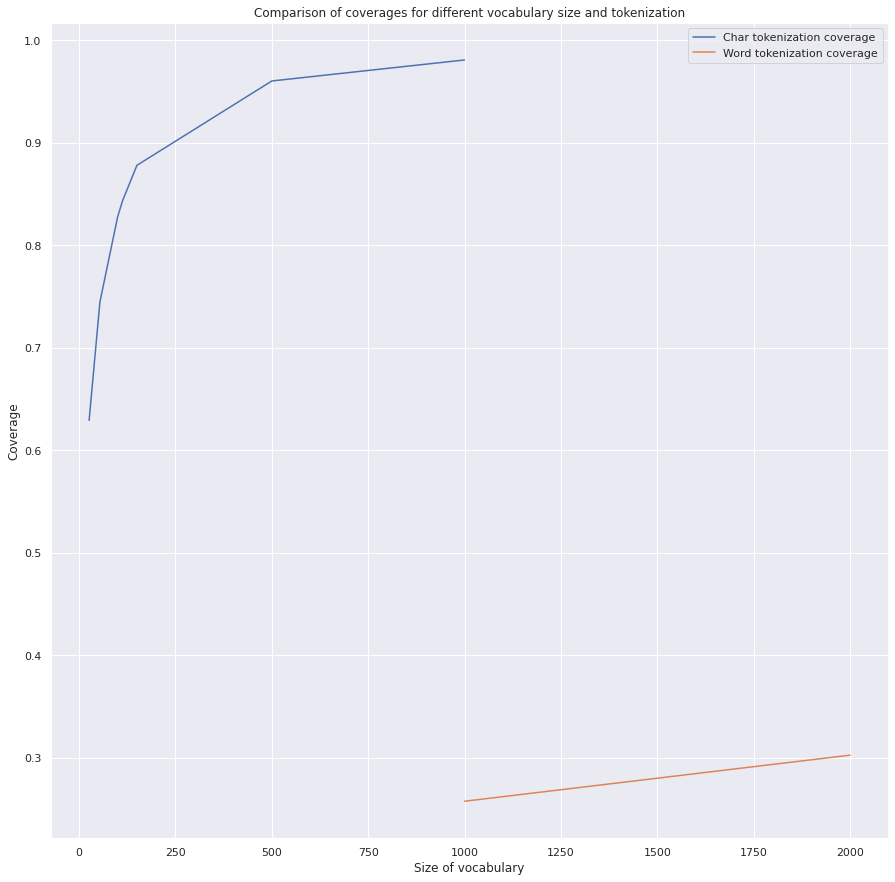

In [ ]:
# Char experiments points
voc_char = [26,54,100,112,113,150,500,1000]
cov_char = [0.6292508009476543,0.7447978530108569,0.827842160343621,0.8425847335203817,0.8437185800594531,0.8780710483907213,0.960360956129256,0.9808517331929401]
plt.plot(voc_char, cov_char, label = "Char tokenization coverage")
 
# Word experiments 
voc_word = [1000, 2000, ]
cov_word = [0.25771498027437495,0.30266285567313955]

plt.plot(voc_word, cov_word, label = "Word tokenization coverage")
plt.xlabel('Size of vocabulary')
plt.ylabel('Coverage')
plt.title('Comparison of coverages for different vocabulary size and tokenization')
plt.legend()
plt.show()

**Preprocess**

**Code**

**Experiments and results**

**Conclusions**